In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import copy

os.path.dirname(sys.executable)
sys.path.append('/kuacc/users/baristopal20/SSuperGAN/')

In [3]:
from data.datasets.golden_face_cloze import GoldenFaceClozeDataset
from data.augment import get_PIL_image

from networks.models import FaceClozeModel
from utils.config_utils import read_config, Config
from utils.logging_utils import *
from utils.plot_utils import *

In [4]:
def draw_seq_saliency(model, imgs, y):
    
    B, S, C, H, W = y.shape
    
    h, w = imgs.shape[-2:]
    px = 1/plt.rcParams['figure.dpi']
    fig, ax = plt.subplots(3, S+3)
    fig.set_size_inches((S+3)*w*px, ((S+3)//2)*h*px)
    
    imgs.requires_grad_()
    outs, _ = model(imgs.cuda(), f="seq_encode")
    out = outs.sum()
    out.backward()
    
    g_imgs = imgs.grad
    
    for i in range(3):
        saliency, _ = torch.max(g_imgs[0,i,:,:,:].data.abs(), dim=0) 
        saliency = saliency.reshape(h, w)
        init_img = get_PIL_image(imgs[0,i,:,:,:])
        # Visualize the image and the saliency map
        ax[0, i].imshow(init_img)
        ax[0, i].axis('off')
        ax[0, i].title.set_text("Panel" + str(i+1))
        ax[1, i].imshow(saliency.cpu(), cmap='hot')
        ax[1, i].axis('off')
        ax[2, i].imshow(init_img)
        ax[2, i].imshow(saliency.cpu(), cmap='hot', alpha=0.7)
        ax[2, i].axis('off')
    
    
    for s in range(S):
    
        target = get_PIL_image(y[0,s,:,:,:])
        ax[0, s+3].imshow(target)
        ax[0, s+3].title.set_text("Opt." + str(s+1))
        ax[1, s+3].imshow(target)
        ax[2, s+3].imshow(target)
    
    plt.tight_layout()
    plt.show() 

In [5]:
golden_age_config = read_config(Config.GOLDEN_AGE)
config = read_config(Config.SSUPERGLOBALDCGAN)
model_path = "ckpts/face_cloze_model-checkpoint-epoch45.pth"

In [6]:
net = FaceClozeModel(
    backbone=config.backbone,
    embed_dim=config.embed_dim,
    latent_dim=config.latent_dim,
    img_size=config.img_size,
    use_lstm=config.use_lstm,
    gen_channels=[64, 128, 256, 512],
    local_disc_channels=config.local_disc_channels,
    global_disc_channels=config.global_disc_channels,
    seq_size=config.seq_size,
    lstm_conv=False,
    lstm_bidirectional=config.lstm_bidirectional,
    lstm_hidden=config.lstm_hidden,
    lstm_dropout=config.lstm_dropout,
    fc_hidden_dims=config.fc_hidden_dims,
    fc_dropout=config.fc_dropout,
    num_lstm_layers=config.num_lstm_layers,
    masked_first=config.masked_first
)

net = nn.DataParallel(net)
net.load_state_dict(torch.load(model_path)["model_state_dict"])
net = net.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [7]:
dataset = GoldenFaceClozeDataset(
    golden_age_config.panel_path,
    golden_age_config.sequence_path, 
    golden_age_config.annot_path,
    config.panel_size,
    config.img_size,
    4,
    train_test_ratio=golden_age_config.train_test_ratio,
    train_mode=False,
    limit_size=-1,
    random_order=True,
    augment=False
)

In [8]:
dl = DataLoader(dataset, batch_size=1)
dl_iter = iter(dl)

Diffs: [40958.84  38416.637 44035.477 41686.97 ]
True: 1  | Predicted: 1


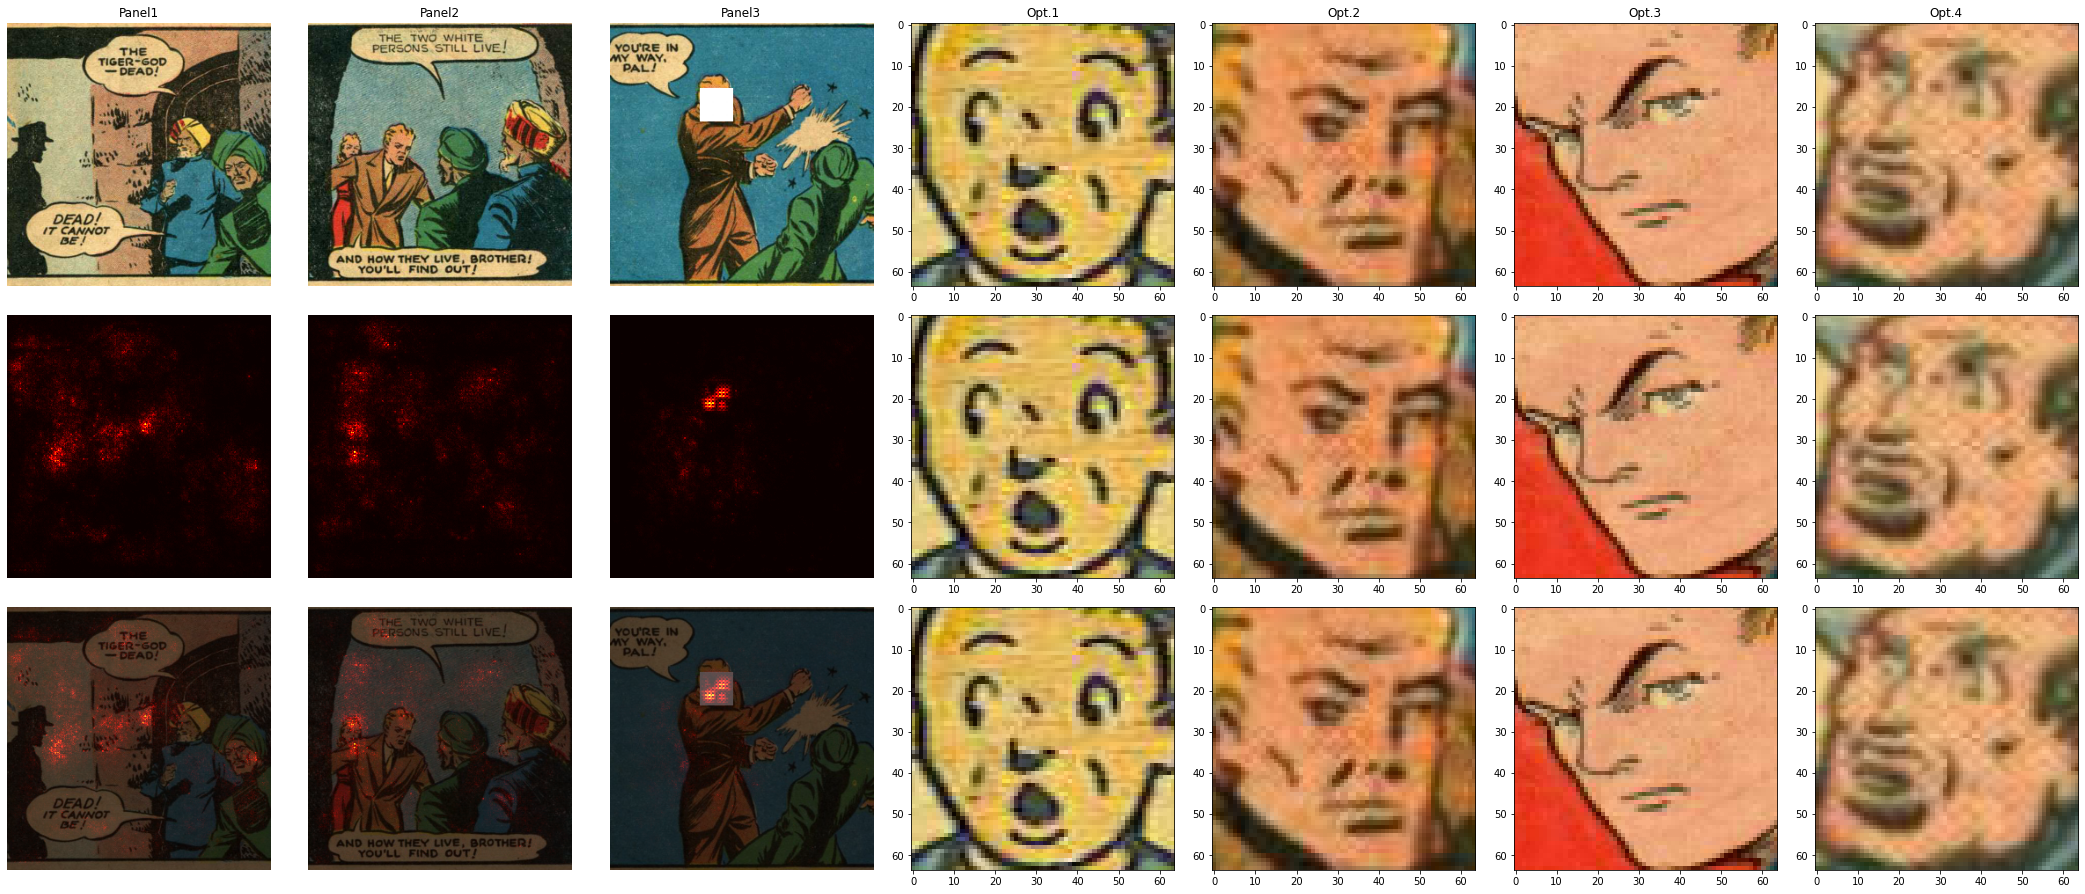

LSTM(1024, 512, bidirectional=True)

In [13]:
x, y, z = next(dl_iter)
x, y, z = x.cuda(), y.cuda(), z.cuda()

B, S, C, H, W = y.shape

seq_emb, _   = net(x, f="seq_encode") 
face_emb, _  = net(y.view(-1, C, H, W), f="encode")
face_emb     = face_emb.view(B, S, -1)
seq_emb      = seq_emb.unsqueeze(1)
diff         = torch.sum((seq_emb - face_emb)**2, dim=-1)
min_diffs    = torch.argmin(diff, dim=1)

print("Diffs:", diff.data.cpu().numpy()[0])
print("True:", z.item(), " | Predicted:", min_diffs.item())

net.module.seq_encoder.lstm.train()
draw_seq_saliency(net, x, y)
net.module.seq_encoder.lstm.eval()